In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train=pd.read_csv('train.tsv',sep='\t')
test=pd.read_csv("test.tsv",sep='\t')

In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
train['Sentiment'].value_counts()


2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [7]:
def change_format(train_data,test_data,max_features,maxlen):
    train_data=train_data.sample(frac=1).reset_index(drop=True)
    #소문자 변경
    train_data['Phrase']=train_data['Phrase'].apply(lambda x:x.lower())
    test_data['Phrase']=test_data['Phrase'].apply(lambda x:x.lower())
    
    X_data=train_data['Phrase']
    test_x=test_data['Phrase']
    
    Y=to_categorical(train_data['Sentiment'].values)
    #자주 사용되는 빈도수가 높은 10000개의 단어만 선택하도록
    tokenizer=Tokenizer(num_words=max_features)
    #단어 인덱스 설계
    tokenizer.fit_on_texts(list(X_data))
    #문자열 정수 인덱스 변환
    X_data=tokenizer.texts_to_sequences(X_data)
    X_data=pad_sequences(X_data,maxlen=maxlen)
    test_x=tokenizer.texts_to_sequences(test_x)
    test_x=pad_sequences(test_x,maxlen=maxlen)
    
    return X_data,Y,test_x

In [8]:
maxlen=125
max_features=10000


In [9]:
X,Y,test_x=change_format(train,test,max_features,maxlen)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,Y,test_size=0.25)

In [11]:
from keras.layers import Dense,Embedding,LSTM
from keras.models import Sequential

In [12]:
model=Sequential()
#embedding 수행하기
model.add(Embedding(max_features,100,mask_zero=True))
#lstm 2개로 학습하기
model.add(LSTM(64,dropout=0.7,recurrent_dropout=0.7,return_sequences=True))
model.add(LSTM(32,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
#fully connected 5개의 평점이여서 5개로 나눰
model.add(Dense(5,activation='sigmoid'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 1,054,821
Trainable params: 1,054,821
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs=5
batch_size=32

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)


Train on 117045 samples, validate on 39015 samples
Epoch 1/5
117045/117045 [==============================] - 773s 7ms/step - loss: 1.1750 - accuracy: 0.5388 - val_loss: 0.9686 - val_accuracy: 0.6080
Epoch 2/5
117045/117045 [==============================] - 792s 7ms/step - loss: 0.9450 - accuracy: 0.6211 - val_loss: 0.8867 - val_accuracy: 0.6390
Epoch 3/5
117045/117045 [==============================] - 780s 7ms/step - loss: 0.8837 - accuracy: 0.6405 - val_loss: 0.8674 - val_accuracy: 0.6446
Epoch 4/5
117045/117045 [==============================] - 786s 7ms/step - loss: 0.8557 - accuracy: 0.6499 - val_loss: 0.8559 - val_accuracy: 0.6482
Epoch 5/5
117045/117045 [==============================] - 750s 6ms/step - loss: 0.8386 - accuracy: 0.6548 - val_loss: 0.8472 - val_accuracy: 0.6508


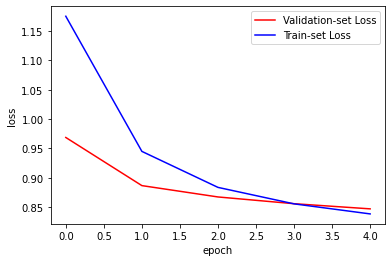

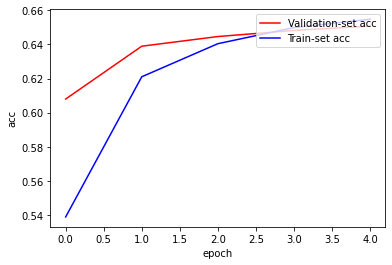

In [26]:


y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss,  c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid(False)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len2 = np.arange(len(y_acc))
plt.plot(x_len2, y_vacc, c='red', label="Validation-set acc")
plt.plot(x_len2, y_acc,  c='blue', label="Train-set acc")

plt.legend(loc='upper right')
plt.grid(False)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [29]:
sub=pd.read_csv('sampleSubmission.csv')
sub['Sentiment']=model.predict_classes(test_x,batch_size=batch_size,verbose=1)
sub.to_csv('submission.csv',index=False)

66292/66292 [==============================] - 118s 2ms/step
